# Config

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
#pip install geopy

In [3]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.geocoders import Nominatim
import sys
import os

In [4]:

current_dir = os.getcwd() # Obtener la ruta del directorio actual del notebook
ROOT_PATH = os.path.dirname(current_dir) # Obtener la ruta del directorio superior
sys.path.insert(1, ROOT_PATH) # Insertar la ruta en sys.path

import root 

In [5]:
# Read datasets
client = pd.read_csv(root.DIR_DATA_RAW + 'client.csv')
electricity_prices = pd.read_csv(root.DIR_DATA_RAW + 'electricity_prices.csv')
gas_prices = pd.read_csv(root.DIR_DATA_RAW + 'gas_prices.csv')
historical_weather = pd.read_csv(root.DIR_DATA_RAW + 'historical_weather.csv')
forecast_weather = pd.read_csv(root.DIR_DATA_RAW + 'forecast_weather.csv')
train = pd.read_csv(root.DIR_DATA_RAW + 'train.csv')

In [6]:
print(electricity_prices.shape)
electricity_prices.head()

(15286, 4)


,forecast_date,euros_per_mwh,origin_date,data_block_id
0,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00,1
1,2021-09-01 01:00:00,88.90,2021-08-31 01:00:00,1
2,2021-09-01 02:00:00,87.35,2021-08-31 02:00:00,1
3,2021-09-01 03:00:00,86.88,2021-08-31 03:00:00,1
4,2021-09-01 04:00:00,88.43,2021-08-31 04:00:00,1


In [7]:
print(gas_prices.shape)
gas_prices.head()

(637, 5)


,forecast_date,lowest_price_per_mwh,highest_price_per_mwh,origin_date,data_block_id
0,2021-09-01,45.23,46.32,2021-08-31,1
1,2021-09-02,45.62,46.29,2021-09-01,2
2,2021-09-03,45.85,46.40,2021-09-02,3
3,2021-09-04,46.30,46.80,2021-09-03,4
4,2021-09-05,46.30,46.58,2021-09-04,5


In [8]:
print(historical_weather.shape)
historical_weather.head()

(1710802, 18)


,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id
0,2021-09-01 00:00:00,14.2,11.6,0.0,0.0,1015.9,31,31,0,11,7.083333,8,0.0,0.0,0.0,57.6,21.7,1.0
1,2021-09-01 00:00:00,13.9,11.5,0.0,0.0,1010.7,33,37,0,0,5.111111,359,0.0,0.0,0.0,57.6,22.2,1.0
2,2021-09-01 00:00:00,14.0,12.5,0.0,0.0,1015.0,31,34,0,0,6.333333,355,0.0,0.0,0.0,57.6,22.7,1.0
3,2021-09-01 00:00:00,14.6,11.5,0.0,0.0,1017.3,0,0,0,0,8.083333,297,358.0,277.0,81.0,57.6,23.2,1.0
4,2021-09-01 00:00:00,15.7,12.9,0.0,0.0,1014.0,22,25,0,0,8.416667,5,0.0,0.0,0.0,57.6,23.7,1.0


In [9]:
print(client.shape)
client.head()

(41919, 7)


,product_type,county,eic_count,installed_capacity,is_business,date,data_block_id
0,1,0,108,952.89,0,2021-09-01,2
1,2,0,17,166.40,0,2021-09-01,2
2,3,0,688,7207.88,0,2021-09-01,2
3,0,0,5,400.00,1,2021-09-01,2
4,1,0,43,1411.00,1,2021-09-01,2


In [10]:
print(train.shape)
train.head()

(2018352, 9)


,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2


In [11]:
# Function to group data
def group_df(base_df, group_cols, group_data={'target': 'sum'}):
    df = base_df.groupby(group_cols).agg(group_data)
    df.reset_index(inplace=True)
    return df

# EDA para filtrar datos
Primero vamos a hacer un EDA para saber cómo hacer el filtrado del dataset ya que este contiene muchos registros y no tenemos la capacidad computacional para correr modelos con tantos datos.

## Consumption data

In [12]:
# Filter consumption data
train_consumption = train[train['is_consumption'] == 0]
train_consumption.head()

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2
6,0,1,0,0.000,0,2021-09-01 00:00:00,0,6,3
8,0,1,1,0.000,0,2021-09-01 00:00:00,0,8,4


<Axes: xlabel='product_type', ylabel='target'>

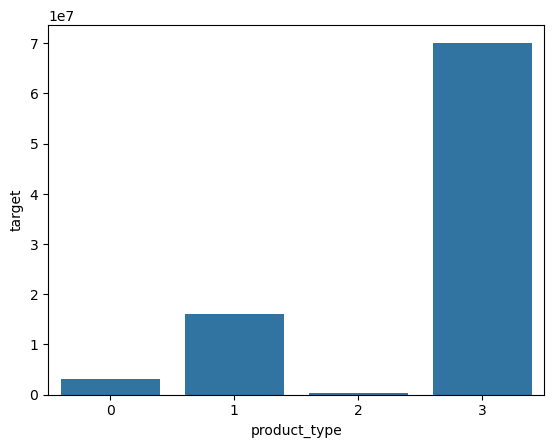

In [13]:
# Group by product_type
train_consumption_product = group_df(train_consumption, ['product_type'])
train_consumption_product.head()
sns.barplot(x='product_type', y='target', data=train_consumption_product)

<Axes: xlabel='is_business', ylabel='target'>

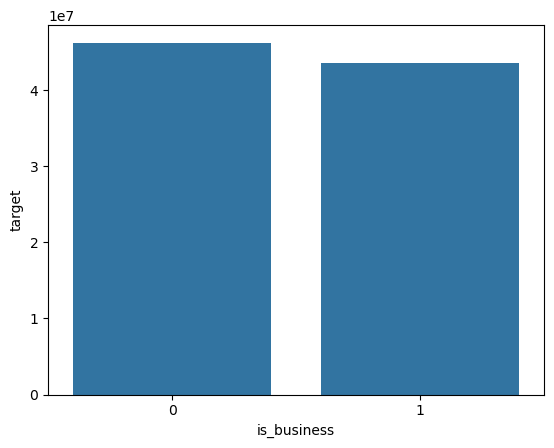

In [14]:
# Group by is_business
train_consumption_business = group_df(train_consumption, ['is_business'])
train_consumption_business.head()
sns.barplot(x='is_business', y='target', data=train_consumption_business)

<Axes: xlabel='is_business', ylabel='target'>

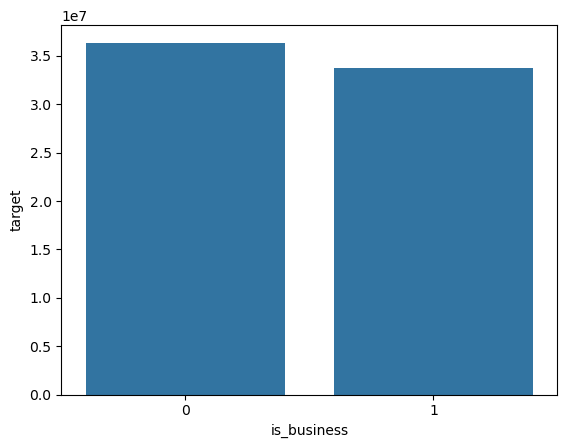

In [15]:
# Group records where product_type=3 by is_business
train_consumption_product3_business = group_df(train_consumption[train_consumption['product_type'] == 3], ['is_business'])
train_consumption_product3_business.head()
sns.barplot(x='is_business', y='target', data=train_consumption_product3_business)

## Production data

In [16]:
# Filter production data
train_production = train[train['is_consumption'] == 1]
train_production.head()

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1
5,0,0,3,656.859,1,2021-09-01 00:00:00,0,5,2
7,0,1,0,59.000,1,2021-09-01 00:00:00,0,7,3
9,0,1,1,501.760,1,2021-09-01 00:00:00,0,9,4


<Axes: xlabel='product_type', ylabel='target'>

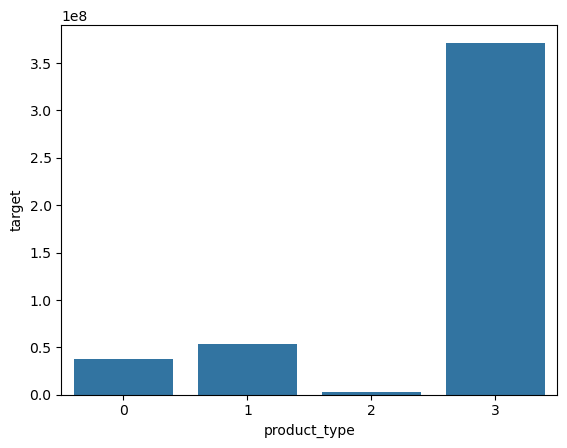

In [17]:
# Group by product_type
train_production_product = group_df(train_production, ['product_type'])
train_production_product.head()
sns.barplot(x='product_type', y='target', data=train_production_product)

<Axes: xlabel='is_business', ylabel='target'>

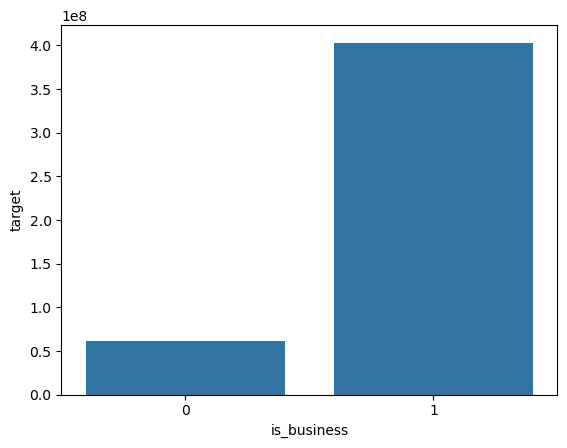

In [18]:
# Group by is_business
train_production_business = group_df(train_production, ['is_business'])
train_production_business.head()
sns.barplot(x='is_business', y='target', data=train_production_business)

<Axes: xlabel='is_business', ylabel='target'>

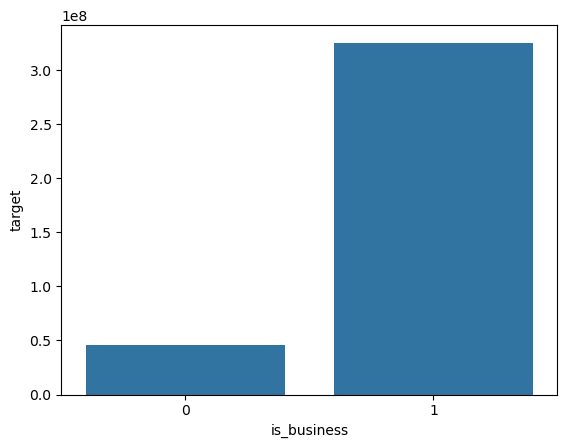

In [19]:
# Group records where product_type=3 by is_business
train_production_product3_business = group_df(train_production[train_production['product_type'] == 3], ['is_business'])
train_production_product3_business.head()
sns.barplot(x='is_business', y='target', data=train_production_product3_business)

**Conclusiones**

- **Dataset de consumo:** el tipo de contrato que más energía consume es el 3 y las empresas son las que más energía consumen. Para el tipo de contrato 3, las empresas son las que más energía consumen.

- **Dataset de consumo:** el tipo de contrato que más energía produce es el 3 y las empresas son las que más energía producen. Para el tipo de contrato 3, las empresas son las que más energía producen.

Debido a que las empresas con tipo de contrato 3 son las que más enegría consumen y producen, nos vamos a enfocar en este segmento, pues esta predicción nos puede ayudar a ahorrar la mayor cantidad de dinero.

## Crear datasets filtrados

Se va a contruir un dataset de consumo y otro de producción de energía. Se va a tomar en cuenta unicamente el semneto de empresas donde el tipo de producto es el 3 (is_business = 1 and product_type = 3).

In [20]:
# Consumption dataset
train_c = train[(train['is_consumption'] == 1) & (train['is_business'] == 1) & (train['product_type'] == 3)]
train_c = train_c.drop(['is_consumption', 'is_business', 'product_type', 'data_block_id', 'row_id', 'prediction_unit_id'], axis=1)
print('Consumption shape:', train_c.shape)
train_c.head()

Consumption shape: (244992, 3)


,county,target,datetime
11,0,5155.056,2021-09-01 00:00:00
17,1,30.778,2021-09-01 00:00:00
21,2,266.637,2021-09-01 00:00:00
29,3,729.075,2021-09-01 00:00:00
37,4,356.901,2021-09-01 00:00:00


In [21]:
# Production dataset
train_p = train[(train['is_consumption'] == 0) & (train['is_business'] == 1) & (train['product_type'] == 3)]
train_p = train_p.drop(['is_consumption', 'is_business', 'product_type', 'data_block_id', 'row_id', 'prediction_unit_id'], axis=1)
print('Production shape:', train_p.shape)
train_p.head()

Production shape: (244992, 3)


,county,target,datetime
10,0,0.315,2021-09-01 00:00:00
16,1,0.000,2021-09-01 00:00:00
20,2,0.000,2021-09-01 00:00:00
28,3,0.000,2021-09-01 00:00:00
36,4,0.000,2021-09-01 00:00:00


In [22]:
# Consumption and production dataset
train = train[(train['is_business'] == 1) & (train['product_type'] == 3)]
train = train.drop(['is_business', 'product_type', 'data_block_id', 'row_id', 'prediction_unit_id'], axis=1)
print('Consumption shape:', train.shape)
train.head()

Consumption shape: (489984, 4)


,county,target,is_consumption,datetime
10,0,0.315,0,2021-09-01 00:00:00
11,0,5155.056,1,2021-09-01 00:00:00
16,1,0.000,0,2021-09-01 00:00:00
17,1,30.778,1,2021-09-01 00:00:00
20,2,0.000,0,2021-09-01 00:00:00


# EDA - historical_weather dataset
FALTA:
- Hacer el EDA de los datos

In [23]:
# Get unique coordinates
coordinates = historical_weather[['longitude', 'latitude']].drop_duplicates()
coordinates

,longitude,latitude
0,21.7,57.6
1,22.2,57.6
2,22.7,57.6
3,23.2,57.6
4,23.7,57.6
...,...,...
107,26.2,59.7
108,26.7,59.7
109,27.2,59.7
110,27.7,59.7


In [24]:
# Get location of coordinates
unknown = 0
coordinates['county'] = ''
geolocator = Nominatim(user_agent="county_locator")

for i in range(len(coordinates)):

    latitude, longitude = coordinates.loc[i, 'latitude'], coordinates.loc[i, 'longitude']
    location = geolocator.reverse((latitude, longitude), language="en")

    if location:
        address = location.raw.get("address", {})
        county = address.get("county", "Unknown")
        coordinates.loc[i, 'county'] = str(county)
    else:
        unknown += 1
        coordinates.loc[i, 'county'] = 'Unknown'
coordinates

,longitude,latitude,county
0,21.7,57.6,Unknown
1,22.2,57.6,Unknown
2,22.7,57.6,Unknown
3,23.2,57.6,Saare County
4,23.7,57.6,Unknown
...,...,...,...
107,26.2,59.7,Lääne-Viru County
108,26.7,59.7,Lääne-Viru County
109,27.2,59.7,Jaama District
110,27.7,59.7,Jaama District


In [25]:
# Locations found
coordinates.county.unique()

array(['Unknown', 'Saare County', 'Võru County', 'Pechorsky District',
       'Palkinsky District', 'Pärnu County', 'Valga County',
       'Pskovsky District', 'Viljandi County', 'Tartu County',
       'Põlva County', 'Gdovsky District', 'Jõgeva County', 'Hiiu County',
       'Lääne County', 'Rapla County', 'Järva County', 'Harju County',
       'Lääne-Viru County', 'Ida-Viru County', 'Slantsevsky District',
       'Jaama District', 'Uusimaa'], dtype=object)

In [26]:
# Dataframe of coordinates that are not a county of Estonia
wrong_coordinates = coordinates[
    coordinates['county'].isin([
        'Unknown',
        'Uusimaa',
        'Slantsevsky District',
        'Jaama District',
        'Gdovsky District',
        'Pskovsky District',
        'Pechorsky District',
        'Palkinsky District'
    ])
]
wrong_coordinates

,longitude,latitude,county
0,21.7,57.6,Unknown
1,22.2,57.6,Unknown
2,22.7,57.6,Unknown
4,23.7,57.6,Unknown
5,24.2,57.6,Unknown
6,24.7,57.6,Unknown
7,25.2,57.6,Unknown
8,25.7,57.6,Unknown
9,26.2,57.6,Unknown
12,27.7,57.6,Pechorsky District


**Conclusiones**

- Se pueden eliminar los registros del clima de las siguientes locaciones, ya que NO pertenecen a ningun lugar de Estonia: Unknown, Uusimaa, Slantsevsky District, Jaama District, Gdovsky District, Pskovsky District, Pechorsky District, Palkinsky District.
- Se pueden identificar los 15 counties que existen en Estonia.

In [27]:
# Merge historical_weather with location
historical_weather = historical_weather.merge(
    coordinates[['latitude', 'longitude', 'county']],
    on=['latitude', 'longitude']
)
historical_weather = historical_weather.drop(['longitude', 'latitude'], axis=1)
historical_weather.head()

,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,data_block_id,county
0,2021-09-01 00:00:00,14.2,11.6,0.0,0.0,1015.9,31,31,0,11,7.083333,8,0.0,0.0,0.0,1.0,Unknown
1,2021-09-01 00:00:00,13.9,11.5,0.0,0.0,1010.7,33,37,0,0,5.111111,359,0.0,0.0,0.0,1.0,Unknown
2,2021-09-01 00:00:00,14.0,12.5,0.0,0.0,1015.0,31,34,0,0,6.333333,355,0.0,0.0,0.0,1.0,Unknown
3,2021-09-01 00:00:00,14.6,11.5,0.0,0.0,1017.3,0,0,0,0,8.083333,297,358.0,277.0,81.0,1.0,Saare County
4,2021-09-01 00:00:00,15.7,12.9,0.0,0.0,1014.0,22,25,0,0,8.416667,5,0.0,0.0,0.0,1.0,Unknown


In [28]:
# Drop historical_weather rows that are not from a county of Estonia
wrong_locations = wrong_coordinates.county.unique()
historical_weather = historical_weather[~historical_weather['county'].isin(wrong_locations)]
historical_weather.head()

,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,data_block_id,county
3,2021-09-01 00:00:00,14.6,11.5,0.0,0.0,1017.3,0,0,0,0,8.083333,297,358.0,277.0,81.0,1.0,Saare County
10,2021-09-01 00:00:00,13.0,11.5,0.0,0.0,998.5,100,85,17,98,4.027778,354,0.0,0.0,0.0,1.0,Võru County
11,2021-09-01 00:00:00,13.0,12.1,0.1,0.0,988.9,100,100,39,99,3.805556,360,0.0,0.0,0.0,1.0,Võru County
14,2021-09-01 00:00:00,13.3,10.7,0.0,0.0,1016.2,51,35,0,64,7.611111,5,0.0,0.0,0.0,1.0,Saare County
15,2021-09-01 00:00:00,14.4,11.3,0.0,0.0,1016.2,51,35,0,64,7.611111,5,0.0,0.0,0.0,1.0,Saare County


In [29]:
# Check that all the rows in historical_weather are from a county in Estonia
print('Counties:', historical_weather.county.unique())
print('Number of counties:', len(historical_weather.county.unique()))

Counties: ['Saare County' 'Võru County' 'Pärnu County' 'Valga County'
 'Viljandi County' 'Tartu County' 'Põlva County' 'Jõgeva County'
 'Hiiu County' 'Lääne County' 'Rapla County' 'Järva County' 'Harju County'
 'Lääne-Viru County' 'Ida-Viru County']
Number of counties: 15


In [30]:
# Change county name to an integer (the same as the test dataset)
county_to_int = {'Saare County' : 10,
                 'Võru County' : 15,
                 'Pärnu County' : 7,
                 'Valga County' : 13,
                 'Viljandi County' : 14,
                 'Tartu County' : 11,
                 'Põlva County' : 8,
                 'Jõgeva County' : 4,
                 'Hiiu County' : 1,
                 'Lääne County' : 6,
                 'Rapla County' : 9,
                 'Järva County' : 3,
                 'Harju County' : 0,
                 'Lääne-Viru County' : 5,
                 'Ida-Viru County' : 2}

historical_weather['county'] = historical_weather['county'].map(county_to_int)
historical_weather.head()

,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,data_block_id,county
3,2021-09-01 00:00:00,14.6,11.5,0.0,0.0,1017.3,0,0,0,0,8.083333,297,358.0,277.0,81.0,1.0,10
10,2021-09-01 00:00:00,13.0,11.5,0.0,0.0,998.5,100,85,17,98,4.027778,354,0.0,0.0,0.0,1.0,15
11,2021-09-01 00:00:00,13.0,12.1,0.1,0.0,988.9,100,100,39,99,3.805556,360,0.0,0.0,0.0,1.0,15
14,2021-09-01 00:00:00,13.3,10.7,0.0,0.0,1016.2,51,35,0,64,7.611111,5,0.0,0.0,0.0,1.0,10
15,2021-09-01 00:00:00,14.4,11.3,0.0,0.0,1016.2,51,35,0,64,7.611111,5,0.0,0.0,0.0,1.0,10


In [31]:
# Change column datetime to datetime type
historical_weather['datetime'] = pd.to_datetime(historical_weather['datetime'])

Descriptive Statistics:
        temperature      dewpoint          rain      snowfall  \
count  1.145626e+06  1.145626e+06  1.145626e+06  1.145626e+06   
mean   5.718322e+00  2.183928e+00  4.802885e-02  1.590570e-02   
std    8.083312e+00  7.212783e+00  2.009394e-01  7.452394e-02   
min   -2.340000e+01 -2.580000e+01  0.000000e+00  0.000000e+00   
max    3.260000e+01  2.210000e+01  1.680000e+01  2.660000e+00   

       surface_pressure  cloudcover_total  cloudcover_low  cloudcover_mid  \
count      1.145626e+06      1.145626e+06    1.145626e+06    1.145626e+06   
mean       1.008978e+03      6.108484e+01    4.686660e+01    3.441099e+01   
std        1.320686e+01      3.765268e+01    4.059422e+01    3.826683e+01   
min        9.429000e+02      0.000000e+00    0.000000e+00    0.000000e+00   
max        1.049300e+03      1.000000e+02    1.000000e+02    1.000000e+02   

       cloudcover_high  windspeed_10m  winddirection_10m  shortwave_radiation  \
count     1.145626e+06   1.145626e+06    

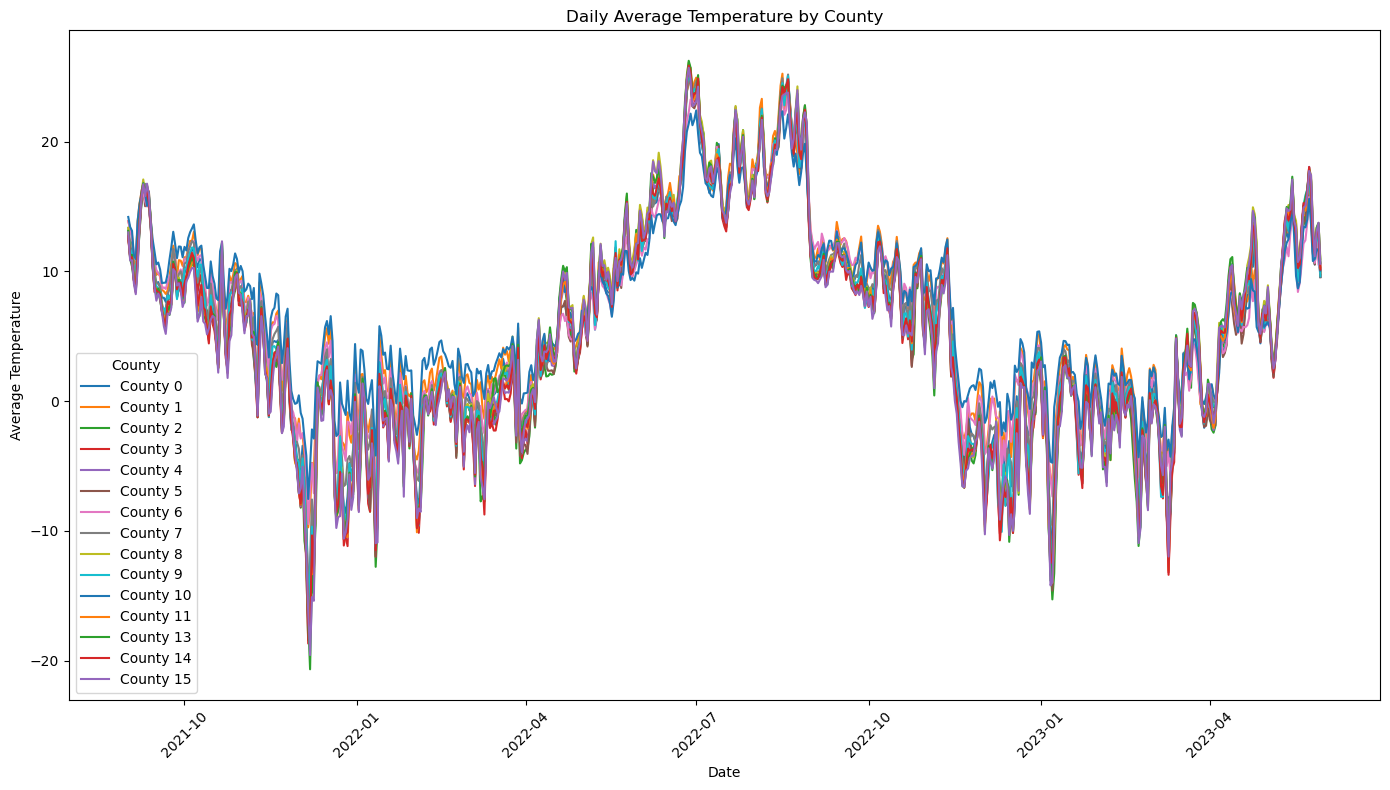

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'historical_weather' is your DataFrame
# Ensure 'datetime' is in datetime format
historical_weather['datetime'] = pd.to_datetime(historical_weather['datetime'])

# Generate descriptive statistics
columns_of_interest = [
    'temperature', 'dewpoint', 'rain', 'snowfall', 'surface_pressure',
    'cloudcover_total', 'cloudcover_low', 'cloudcover_mid', 'cloudcover_high',
    'windspeed_10m', 'winddirection_10m', 'shortwave_radiation',
    'direct_solar_radiation', 'diffuse_radiation', 'data_block_id'
]

stats = historical_weather[columns_of_interest].agg(['count', 'mean', 'std', 'min', 'max'])
print("Descriptive Statistics:")
print(stats)

# Calculate daily average temperature by county
daily_avg_temp = historical_weather.groupby([historical_weather['datetime'].dt.date, 'county']).agg({'temperature': 'mean'}).reset_index()

plt.figure(figsize=(14, 8))

# Loop through each county and plot its daily average temperature
for county in daily_avg_temp['county'].unique():
    county_data = daily_avg_temp[daily_avg_temp['county'] == county]
    plt.plot(county_data['datetime'], county_data['temperature'], label=f'County {county}')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Average Temperature')
plt.title('Daily Average Temperature by County')
plt.legend(title="County")
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


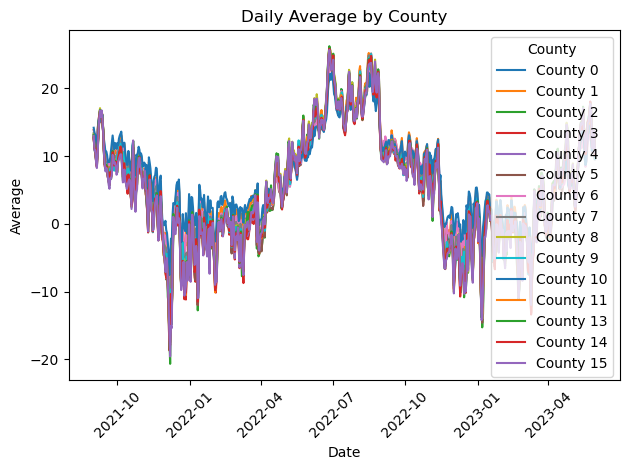

In [33]:
daily_avg_temp = group_df(historical_weather, [historical_weather['datetime'].dt.date, 'county'], group_data={'temperature': 'mean'})

# Loop through each county and plot its daily average temperature
for county in daily_avg_temp['county'].unique():
    county_data = daily_avg_temp[daily_avg_temp['county'] == county]
    plt.plot(county_data['datetime'], county_data['temperature'], label=f'County {county}')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Average')
plt.title('Daily Average by County')
plt.legend(title="County")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [34]:
historical_weather.describe()

,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,data_block_id,county
count,1145626,1.145626e+06,1.145626e+06,1.145626e+06,1.145626e+06,1.145626e+06,1.145626e+06,1.145626e+06,1.145626e+06,1.145626e+06,1.145626e+06,1.145626e+06,1.145626e+06,1.145626e+06,1.145626e+06,1.145626e+06,1.145626e+06
mean,2022-07-16 05:00:09.006080256,5.718322e+00,2.183928e+00,4.802885e-02,1.590570e-02,1.008978e+03,6.108484e+01,4.686660e+01,3.441099e+01,3.607354e+01,4.711469e+00,1.981747e+02,1.061052e+02,6.403163e+01,4.207357e+01,3.192707e+02,6.466670e+00
min,2021-09-01 00:00:00,-2.340000e+01,-2.580000e+01,0.000000e+00,0.000000e+00,9.429000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
25%,2022-02-07 02:00:00,-1.000000e-01,-2.700000e+00,0.000000e+00,0.000000e+00,1.001200e+03,2.500000e+01,3.000000e+00,0.000000e+00,0.000000e+00,2.944444e+00,1.400000e+02,0.000000e+00,0.000000e+00,0.000000e+00,1.600000e+02,2.000000e+00
50%,2022-07-16 05:00:00,5.200000e+00,1.600000e+00,0.000000e+00,0.000000e+00,1.010100e+03,7.200000e+01,4.000000e+01,1.600000e+01,1.000000e+01,4.416667e+00,2.080000e+02,1.000000e+00,0.000000e+00,1.000000e+00,3.190000e+02,7.000000e+00
75%,2022-12-22 08:00:00,1.120000e+01,7.100000e+00,0.000000e+00,0.000000e+00,1.017800e+03,1.000000e+02,9.300000e+01,7.100000e+01,8.500000e+01,6.083333e+00,2.620000e+02,1.390000e+02,4.800000e+01,7.400000e+01,4.780000e+02,1.000000e+01
max,2023-05-30 10:00:00,3.260000e+01,2.210000e+01,1.680000e+01,2.660000e+00,1.049300e+03,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,2.175000e+01,3.600000e+02,8.490000e+02,7.540000e+02,3.860000e+02,6.370000e+02,1.500000e+01
std,NaN,8.083312e+00,7.212783e+00,2.009394e-01,7.452394e-02,1.320686e+01,3.765268e+01,4.059422e+01,3.826683e+01,4.129088e+01,2.343591e+00,8.954960e+01,1.792225e+02,1.324876e+02,6.206243e+01,1.837298e+02,4.596618e+00


In [35]:
# Group data by county and datetype, get avg from all cols
historical_weather = group_df(historical_weather, ['county', 'datetime'], 'mean')
historical_weather.head(3)

,county,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,data_block_id
0,0,2021-09-01 00:00:00,13.79,10.73,0.0,0.0,1010.56,54.4,56.9,3.5,3.9,5.325000,342.0,0.0,0.0,0.0,1.0
1,0,2021-09-01 01:00:00,13.62,10.35,0.0,0.0,1010.47,28.9,26.0,1.1,15.8,5.327778,345.8,0.0,0.0,0.0,1.0
2,0,2021-09-01 02:00:00,13.13,10.07,0.0,0.0,1010.14,13.7,14.5,0.1,1.8,5.091667,340.8,0.0,0.0,0.0,1.0


In [36]:
# Drop data_block_id column
historical_weather = historical_weather.drop(['data_block_id'], axis=1)
historical_weather.head(2)

,county,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation
0,0,2021-09-01 00:00:00,13.79,10.73,0.0,0.0,1010.56,54.4,56.9,3.5,3.9,5.325000,342.0,0.0,0.0,0.0
1,0,2021-09-01 01:00:00,13.62,10.35,0.0,0.0,1010.47,28.9,26.0,1.1,15.8,5.327778,345.8,0.0,0.0,0.0


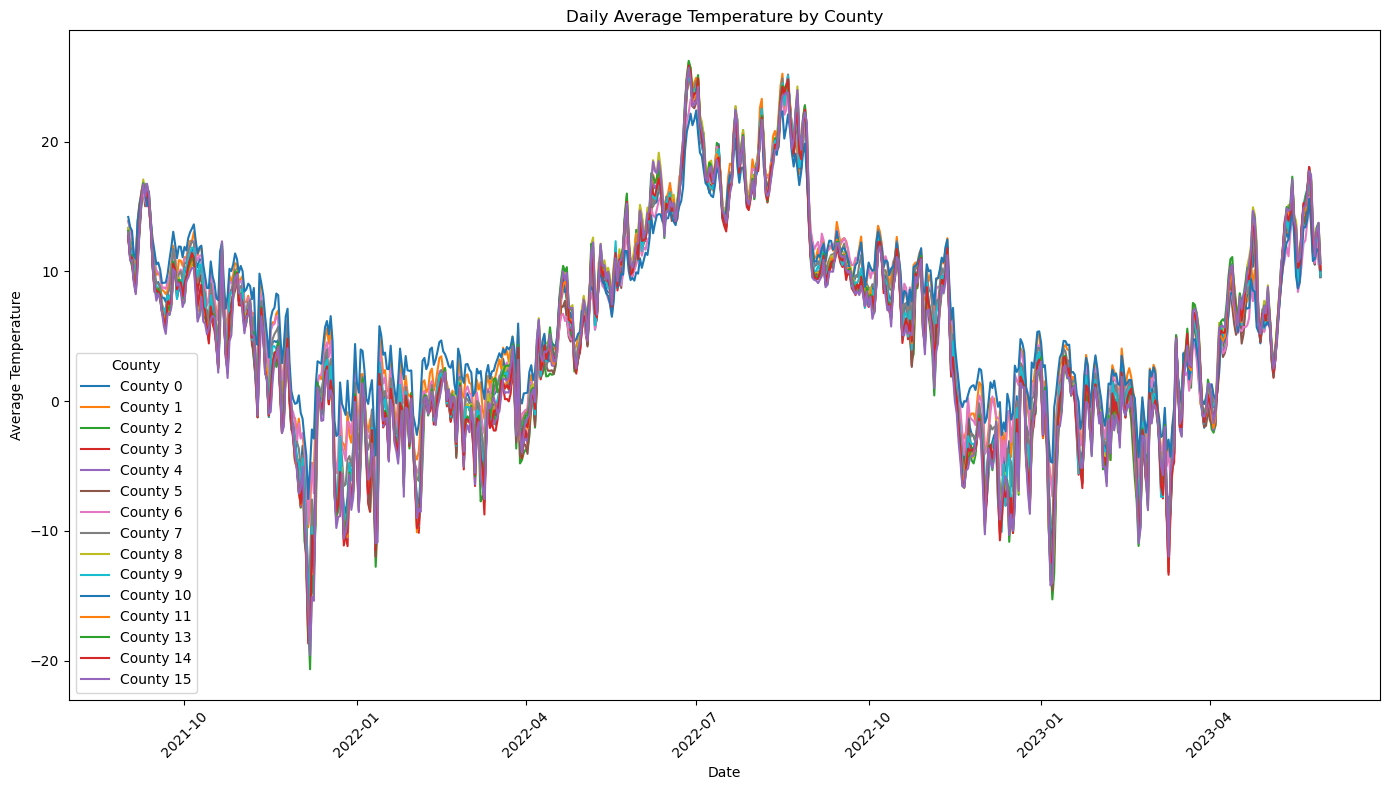

In [37]:
daily_avg_temp = group_df(historical_weather, [historical_weather['datetime'].dt.date, 'county'], group_data={'temperature': 'mean'})

plt.figure(figsize=(14, 8))

# Loop through each county and plot its daily average temperature
for county in daily_avg_temp['county'].unique():
    county_data = daily_avg_temp[daily_avg_temp['county'] == county]
    plt.plot(county_data['datetime'], county_data['temperature'], label=f'County {county}')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Average Temperature')
plt.title('Daily Average Temperature by County')
plt.legend(title="County")
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

<Axes: xlabel='county', ylabel='temperature'>

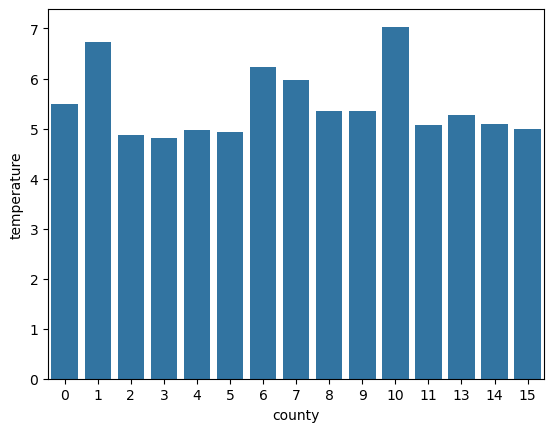

In [38]:
daily_avg_temp = group_df(historical_weather, ['county'], group_data={'temperature': 'mean'})
daily_avg_temp
sns.barplot(x='county', y='temperature', data=daily_avg_temp)

# EDA - train dataset
FALTA:
- EDA por county

# Dataset finales

In [39]:
train_c.head()

,county,target,datetime
11,0,5155.056,2021-09-01 00:00:00
17,1,30.778,2021-09-01 00:00:00
21,2,266.637,2021-09-01 00:00:00
29,3,729.075,2021-09-01 00:00:00
37,4,356.901,2021-09-01 00:00:00


In [40]:
train_p.head()

,county,target,datetime
10,0,0.315,2021-09-01 00:00:00
16,1,0.000,2021-09-01 00:00:00
20,2,0.000,2021-09-01 00:00:00
28,3,0.000,2021-09-01 00:00:00
36,4,0.000,2021-09-01 00:00:00


In [41]:
historical_weather.head()

,county,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation
0,0,2021-09-01 00:00:00,13.79,10.73,0.0,0.0,1010.56,54.4,56.9,3.5,3.9,5.325000,342.0,0.0,0.0,0.0
1,0,2021-09-01 01:00:00,13.62,10.35,0.0,0.0,1010.47,28.9,26.0,1.1,15.8,5.327778,345.8,0.0,0.0,0.0
2,0,2021-09-01 02:00:00,13.13,10.07,0.0,0.0,1010.14,13.7,14.5,0.1,1.8,5.091667,340.8,0.0,0.0,0.0
3,0,2021-09-01 03:00:00,12.74,9.94,0.0,0.0,1010.09,8.6,6.5,0.9,7.5,4.944444,335.5,0.0,0.0,0.0
4,0,2021-09-01 04:00:00,12.46,10.03,0.0,0.0,1009.83,4.1,2.8,0.6,4.2,4.669444,330.6,0.0,0.0,0.0


In [42]:
historical_weather['date'] = historical_weather['datetime'].dt.date  # Extraer la fecha sin la hora

# Contar registros por día y county
count_per_day_county = historical_weather.groupby(['county', 'date']).size().reset_index(name='record_count')

In [43]:
count_per_day_county

,county,date,record_count
0,0,2021-09-01,24
1,0,2021-09-02,24
2,0,2021-09-03,24
3,0,2021-09-04,24
4,0,2021-09-05,24
...,...,...,...
9550,15,2023-05-26,24
9551,15,2023-05-27,24
9552,15,2023-05-28,24
9553,15,2023-05-29,24


Buscar datos nulos

In [44]:
train_c.isnull().sum()

county       0
target      64
datetime     0
dtype: int64

In [45]:
train_p.isnull().sum()

county       0
target      64
datetime     0
dtype: int64

In [46]:
historical_weather.isnull().sum()

county                    0
datetime                  0
temperature               0
dewpoint                  0
rain                      0
snowfall                  0
surface_pressure          0
cloudcover_total          0
cloudcover_low            0
cloudcover_mid            0
cloudcover_high           0
windspeed_10m             0
winddirection_10m         0
shortwave_radiation       0
direct_solar_radiation    0
diffuse_radiation         0
date                      0
dtype: int64

<Axes: xlabel='county', ylabel='target'>

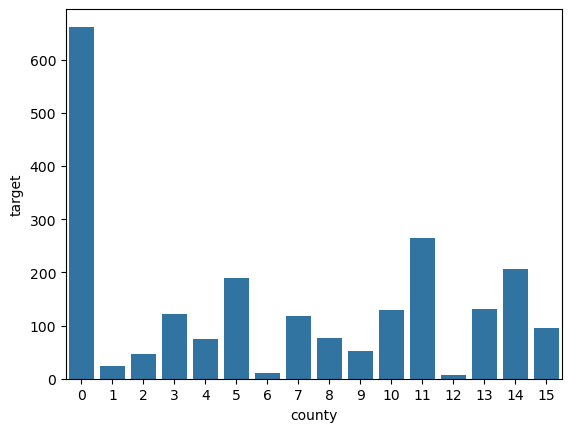

In [47]:
avg_product = group_df(train_p, ['county'], group_data={'target': 'mean'})
avg_product.head()
sns.barplot(x='county', y='target', data=avg_product)

<Axes: xlabel='county', ylabel='target'>

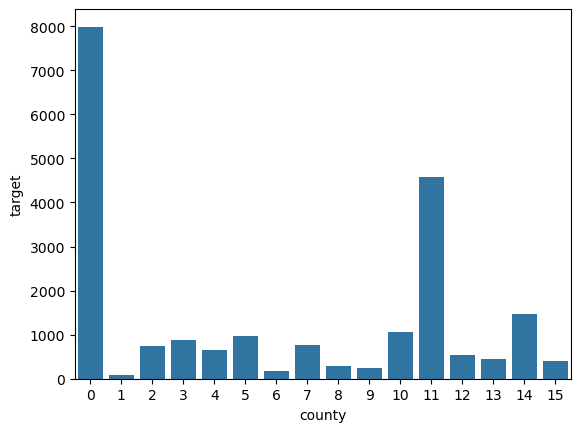

In [48]:
avg_product = group_df(train_c, ['county'], group_data={'target': 'mean'})
avg_product.head()
sns.barplot(x='county', y='target', data=avg_product)

# Guardar los df

### df_consumpion

In [49]:
ruta1 = root.DIR_DATA_RAW + 'train_consumption.csv'
train_c.to_csv(ruta1, index=False) 

### df_generation

In [50]:
ruta2 = root.DIR_DATA_RAW + 'train_production.csv'
train_p.to_csv(ruta2, index=False) 

## Historical weather processeced

In [51]:
ruta3 = root.DIR_DATA_RAW + 'hist_weather_processed.csv'
historical_weather.to_csv(ruta3, index=False) 